# Feature Engineering 

After all flats and points of interests have their geocodes this notebook will 
- Create features based on the macroeconomic data
- Create features based on the distances of HDB flats from points of interests

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import datetime
import matplotlib.pyplot as plt

In [2]:
# This function update the main HDB datdaframe with macroeconomic data from add_factors based on sale date
# feature df is assumed to have date and feature columns

def add_feature(df_house,df_feature,feature,colnum,mthly):
    
    for i in range(len(df_house)):

        # get year and month from hdb_Df
        year = df_house.iloc[i,0].year
        mth = df_house.iloc[i,0].month
        
        #print(year,mth,feature)
        #print(i,colnum,year,mth)

        if mthly:
            df_feature['date'] = pd.to_datetime(df_feature['date'])
            print(i,colnum,year,mth)
            df_house.iloc[i,colnum] = df_feature[(df_feature.date.dt.year==year) & (
                df_feature.date.dt.month==mth)][feature].values[0]
        else:
            df_house.iloc[i,colnum] = df_feature[(df_feature.year==year)][feature].values[0]


In [3]:
# This funcion create new columns for macroeconomic data and send to add_feature for update to HDB dataframe

def add_factors(hdb_df):
    # add composite leading index feature
    cli_df = pd.read_csv("../datasets/macro/cli_cleaned.csv")
    hdb_df['cli'] = 0
    add_feature(hdb_df,cli_df,'cli',hdb_df.shape[1]-1,True)

    # add pmi feature
    pmi_df = pd.read_csv("../datasets/macro/pmi_cleaned.csv")
    hdb_df['pmi'] = 0
    add_feature(hdb_df,pmi_df,'pmi',hdb_df.shape[1]-1,True)

    # add cpf interest rate feature
    cpf_df = pd.read_csv("../datasets/macro/cpf_cleaned.csv")
    hdb_df['cpf_rate'] = 0
    add_feature(hdb_df,cpf_df,'cpf_rate',hdb_df.shape[1]-1,True)

    # add cpi feature
    cpi_df = pd.read_csv("../datasets/macro/cpi_cleaned.csv")
    hdb_df['cpi'] = 0
    add_feature(hdb_df,cpi_df,'cpi',hdb_df.shape[1]-1,True)

    # add gdp growth rate feature
    gdp_df = pd.read_csv("../datasets/macro/gdp_cleaned.csv")
    hdb_df['gdp_growth'] = 0
    add_feature(hdb_df,gdp_df,'gdp_growth',hdb_df.shape[1]-1,True)

    # add unemployment rate feature
    unemployed_df = pd.read_csv("../datasets/macro/unemployed_cleaned.csv")
    hdb_df['unemployed_rate'] = 0
    add_feature(hdb_df,unemployed_df,'unemployed_rate',hdb_df.shape[1]-1,True)
    
    # add sibor feature
    sibor_df = pd.read_csv("../datasets/macro/sibor_cleaned.csv")
    hdb_df['sibor_3m'] = 0
    add_feature(hdb_df,sibor_df,'sibor_3m',hdb_df.shape[1]-1,True)

    # add married feature
    married_df = pd.read_csv("../datasets/macro/married_cleaned.csv")
    hdb_df['married'] = 0
    add_feature(hdb_df,married_df,'married',hdb_df.shape[1]-1,False)

    # add income feature
    income_df = pd.read_csv("../datasets/macro/income_cleaned.csv")
    hdb_df['mth_income'] = 0
    add_feature(hdb_df,income_df,'mth_income',hdb_df.shape[1]-1,False)

    # add hdb price index feature
    hdb_index_df = pd.read_csv("../datasets/macro/hdb_index_cleaned.csv")
    hdb_df['hdb_index'] = 0
    add_feature(hdb_df,hdb_index_df,'hdb_index',hdb_df.shape[1]-1,True)

    # add condo price index feature
    condo_index_df = pd.read_csv("../datasets/macro/condo_index_cleaned.csv")
    hdb_df['condo_index'] = 0
    add_feature(hdb_df,condo_index_df,'condo_index',hdb_df.shape[1]-1,True)

    # add overall pte property price index feature
    pte_index_df = pd.read_csv("../datasets/macro/pte_index_cleaned.csv")
    hdb_df['pte_index'] = 0
    add_feature(hdb_df,pte_index_df,'pte_index',hdb_df.shape[1]-1,True)

    # add total residents feature
    pop_df = pd.read_csv("../datasets/macro/pop_cleaned.csv")
    hdb_df['total_residents'] = 0
    add_feature(hdb_df,pop_df,'total_residents',hdb_df.shape[1]-1,False)

    # add new flat offered feature
    bto_flat_df = pd.read_csv("../datasets/macro/bto_flat_cleaned.csv")
    hdb_df['new_flat_offered'] = 0
    add_feature(hdb_df,bto_flat_df,'new_flat_offered',hdb_df.shape[1]-1,False)

    # add new private home offered feature
    pte_home_df = pd.read_csv("../datasets/macro/new_pte_home_cleaned.csv")
    hdb_df['new_pte_home_offered'] = 0
    add_feature(hdb_df,pte_home_df,'new_pte_home_offered',hdb_df.shape[1]-1,True)

### Calculate distances

There are 3 functions involved - add_poi_dist go through all HDB flat records, nearest_point get the nearest POI with respect to each HDB flat, and haversine_distance calculate the distance based on Haversine Theory.

https://towardsdatascience.com/heres-how-to-calculate-distance-between-2-geolocations-in-python-93ecab5bbba4

In [4]:
# calculate distance in metre using 2 sets of lat/long
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res*1000, 2)

In [5]:
# After getting all distances between flat and point of interest it return the shortest one

def nearest_point(df,lat,lng):
    distances = []
    
    for h in range(len(df)):
        distances.append(
            haversine_distance(lat, lng, df.iloc[h,1], df.iloc[h,2])
        )
        
    distances.sort()
    
    return distances[:1][0]


In [6]:
# This function add a new column for each point of interest and update it with 
# the shortest distance between each flat and the point of interst

def add_poi_dist(df):
        
    station_df = pd.read_csv('../datasets/poi/mrt_cleaned.csv')
    df['dist_mrt'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(station_df,df.iloc[h,61],df.iloc[h,62])

    print('MRT station completed')

    mall_df = pd.read_csv('../datasets/poi/mall_geocoded.csv')
    df['dist_mall'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(mall_df,df.iloc[h,61],df.iloc[h,62])

    print('Malls completed')

    market_df = pd.read_csv('../datasets/poi/hawker_market_cleaned.csv')
    df['dist_market'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(market_df,df.iloc[h,61],df.iloc[h,62])

    print('Hawker Market completed')

    park_df = pd.read_csv('../datasets/poi/park_cleaned.csv')
    df['dist_park'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(park_df,df.iloc[h,61],df.iloc[h,62])

    print('Park completed')

    attraction_df = pd.read_csv('../datasets/poi/attraction_cleaned.csv')
    df['dist_attraction'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(attraction_df,df.iloc[h,61],df.iloc[h,62])
    print('attraction completed')

    sport_df = pd.read_csv('../datasets/poi/sport_cleaned.csv')
    df['dist_sport'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(sport_df,df.iloc[h,61],df.iloc[h,62])
    print('Sport completed')
    

    library_df = pd.read_csv('../datasets/poi/library_cleaned.csv')
    df['dist_library'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(library_df,df.iloc[h,61],df.iloc[h,62])

    print('library completed')

    # People are only concerned about primary schools because it affects their children admission
    school_df = pd.read_csv('../datasets/poi/school_geocoded.csv')
    school_df = school_df[school_df['mainlevel_code']=='primary']
    df['dist_school'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = nearest_point(school_df,df.iloc[h,61],df.iloc[h,62])
        
    print('school completed')

In [7]:
# This function add a new column "core" and update it with the distance from each flat to the core

def add_core_dist(df):
    
    # define the core geopoint
    lat = 1.284428
    lng = 103.851111

    df['dist_core'] = 0
    for h in range(len(df)):
        df.iloc[h,df.shape[1]-1] = haversine_distance(lat, lng, df.iloc[h,61],df.iloc[h,62])

In [8]:
combined = pd.read_csv("../datasets/combined/combined_2015_2020_featured.csv")
combined['sale_date'] = pd.to_datetime(combined['sale_date'])

### Add features to HDB datasets

This takes a very long time to process, so the data is broken down and processed for one year at a time 

In [9]:
# Import the resale transactions that have been geocoded 
# Cast sale_date as date field

hdb_2015 = pd.read_csv("../datasets/hdb/hdb_resale_2015_geocoded.csv")
hdb_2015['sale_date'] = pd.to_datetime(hdb_2015['sale_date'])

hdb_2016 = pd.read_csv("../datasets/hdb/hdb_resale_2016_geocoded.csv")
hdb_2016['sale_date'] = pd.to_datetime(hdb_2016['sale_date'])

hdb_2017 = pd.read_csv("../datasets/hdb/hdb_resale_2017_geocoded.csv")
hdb_2017['sale_date'] = pd.to_datetime(hdb_2017['sale_date'])

hdb_2018 = pd.read_csv("../datasets/hdb/hdb_resale_2018_geocoded.csv")
hdb_2018['sale_date'] = pd.to_datetime(hdb_2018['sale_date'])

hdb_2019 = pd.read_csv("../datasets/hdb/hdb_resale_2019_geocoded.csv")
hdb_2019['sale_date'] = pd.to_datetime(hdb_2019['sale_date'])

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (61) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### I have blocked calling of functions as it will take hours to process

In [10]:
# Add macroecnomic factors as new features to HDB flat datasets
# add_factors(hdb_2015)

# Calculate distances between POI and HDB flat and add the as features to HDB flat datasets
# add_poi_dist(hdb_2015)

# add distance to downtown core
# add_core_dist(hdb_2015)

# save as file by year
# hdb_2015.to_csv("../datasets/combined/combined_2015_featured.csv", index=False)

### Combine the 4 datasets

After features have been added to all datasets it is time to combine them for more preprocessing work

In [11]:
data_2015 = pd.read_csv("../datasets/combined/combined_2015_featured.csv")
data_2016 = pd.read_csv("../datasets/combined/combined_2016_featured.csv")
data_2017 = pd.read_csv("../datasets/combined/combined_2017_featured.csv")
data_2018 = pd.read_csv("../datasets/combined/combined_2018_featured.csv")
data_2019 = pd.read_csv("../datasets/combined/combined_2019_featured.csv")

In [12]:
# merge the datasets into one
combined = pd.concat([data_2015,data_2016,data_2017,data_2018, data_2019],ignore_index=True)

# commented out to avoid overwriting the processed data 
# combined.to_csv("../datasets/combined/combined_2015_2019_featured.csv",index=False)

### Take a look at how the distances affect the prices

In [13]:
# Function to plot Distance of Points of Interest from flats

def plot_poi(df,poi,poi_text):
    x = df[poi]
    y = df['resale_price']

    plt.figure(figsize=(15,8))
    plt.grid(axis='both')
    plt.title('HDB Resale Price vs Distance from '+poi_text, fontsize=15)
    sns.regplot(x, y,ci=None, data=df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

In [14]:
df = pd.read_csv("../datasets/combined/combined_2015_2020_featured.csv")
df['sale_date'] = pd.to_datetime(df['sale_date'])

In [15]:
# check relationship between distance features and target
X = df[['dist_mrt','dist_library','dist_park','dist_market','dist_mall','dist_sport','dist_core',
        'dist_school','dist_attraction']]
X.apply(lambda x: x.corr(df.resale_price))

dist_mrt          -0.168098
dist_library       0.009929
dist_park         -0.106923
dist_market       -0.037579
dist_mall         -0.083712
dist_sport        -0.015020
dist_core         -0.291153
dist_school        0.028919
dist_attraction   -0.168113
dtype: float64

#### Please refer to the plots below this comment

Prices are clearly higher for being near to MRT stations, Shopping Malls, Nature Parks and Attractions
- Public transport usage has increased steadily over the years, and at least [40% of those trips are on MRT](https://www.budgetdirect.com.sg/car-insurance/research/public-transport-singapore), which made proximity to MRT station a highly influential factor in home prices.
- More locals, especially the younger ones, prefer to shop in airconditioned shopping malls, which contributes to higher flat prices near to shopping malls
- Other than shopping malls people are also willing to pay more to be near to nature parks
- Most attractions are in the downtown area, so flats near to town command higher prices

Prices are marginally higher for being near to traditional hawker centres and markets. This reflects the changing lifestyle of locals - nowadays they prefer to visit airconditioned shopping malls with supermarket and many other services under one roof.

Prices are marginally higher for flats near to sports facilities. It is not necessary to visit a sports facility to exercise. Many people, including me, prefer to visit a nature park.  

It appears that locals do not consider proximity to a library to be a bonus, perhaps because more and more reading materials are now available online.

The priority for admission to a primary school is given to those living nearby, so there is an advantage to be near a good primary school. Other than that many people dislike the noise and traffic jam around a school. This probably explains why the home further away from primary schools fetch higher prices.

You may have noticed a small cluster of data points on the extreme right for MRT, malls, libraries and schools. These are flats in new HDB town where amenities have not been fully developed. That is one reason why people prefer mature estates.

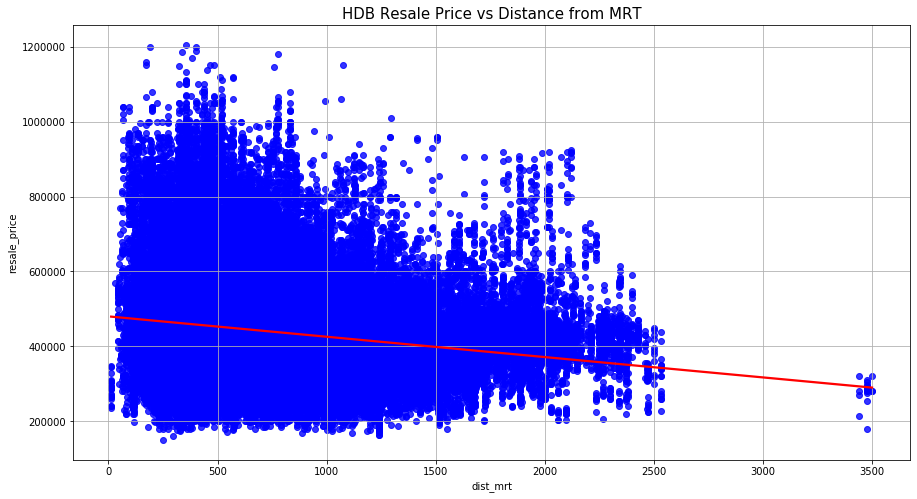

In [16]:
plot_poi(combined,'dist_mrt','MRT')

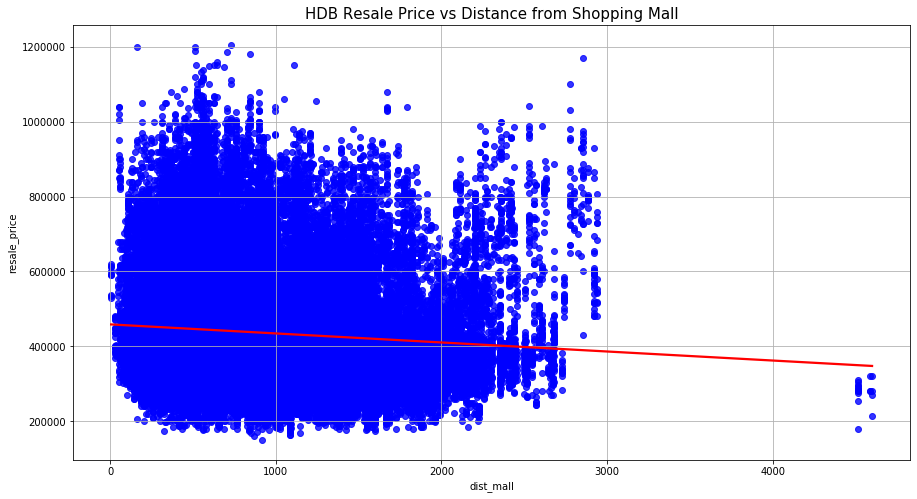

In [17]:
plot_poi(combined,'dist_mall','Shopping Mall')

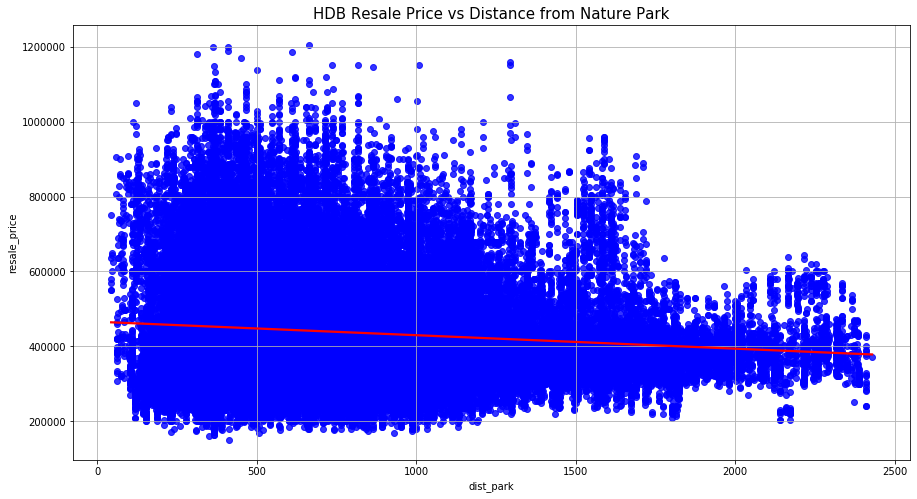

In [18]:
plot_poi(combined,'dist_park','Nature Park')

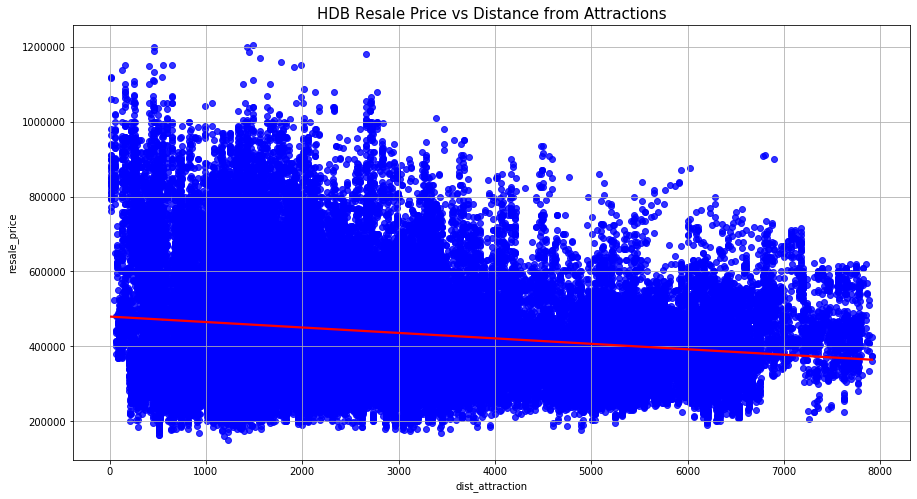

In [19]:
plot_poi(combined,'dist_attraction','Attractions')

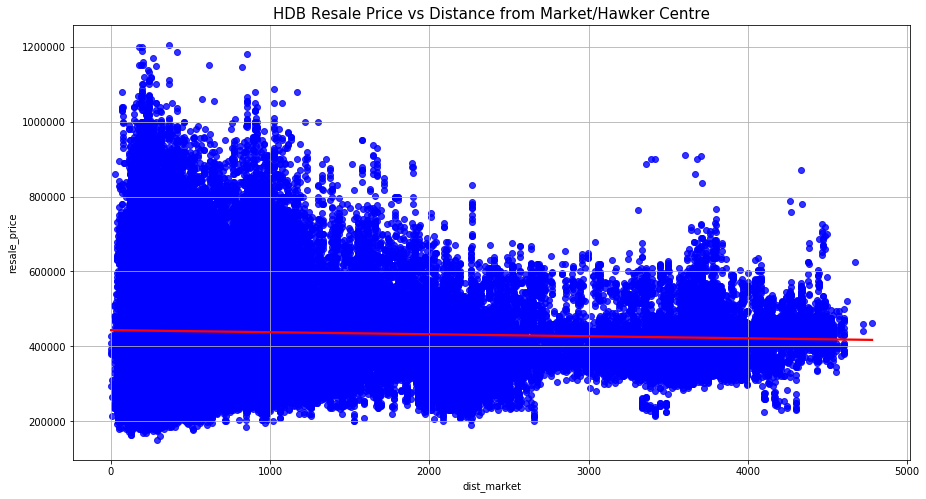

In [20]:
plot_poi(combined,'dist_market','Market/Hawker Centre')

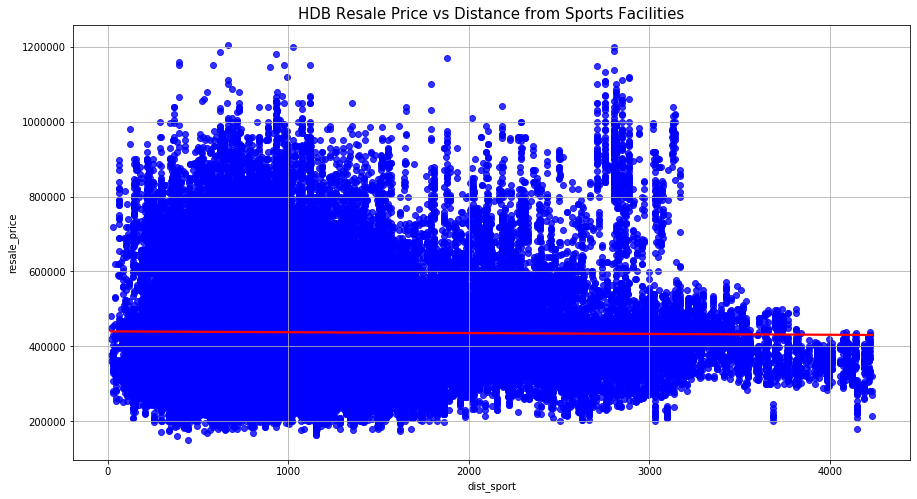

In [21]:
plot_poi(combined,'dist_sport','Sports Facilities')

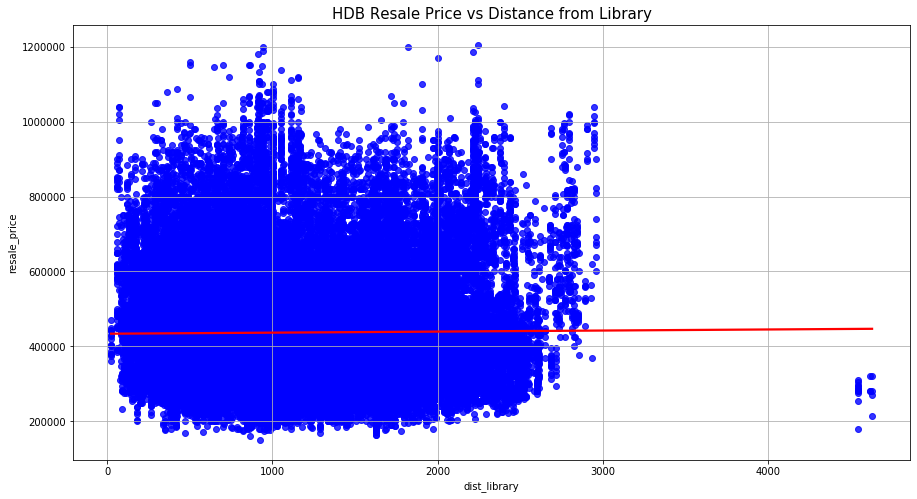

In [22]:
plot_poi(combined,'dist_library','Library')

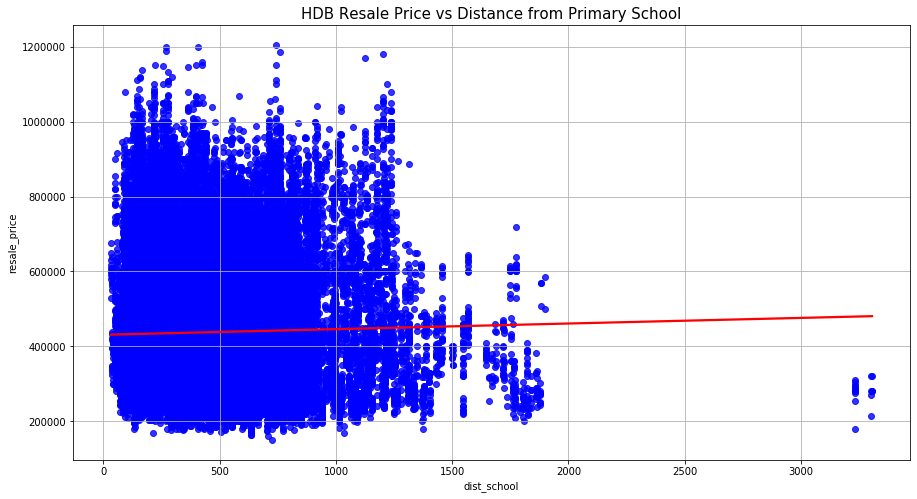

In [23]:
plot_poi(combined,'dist_school','Primary School')

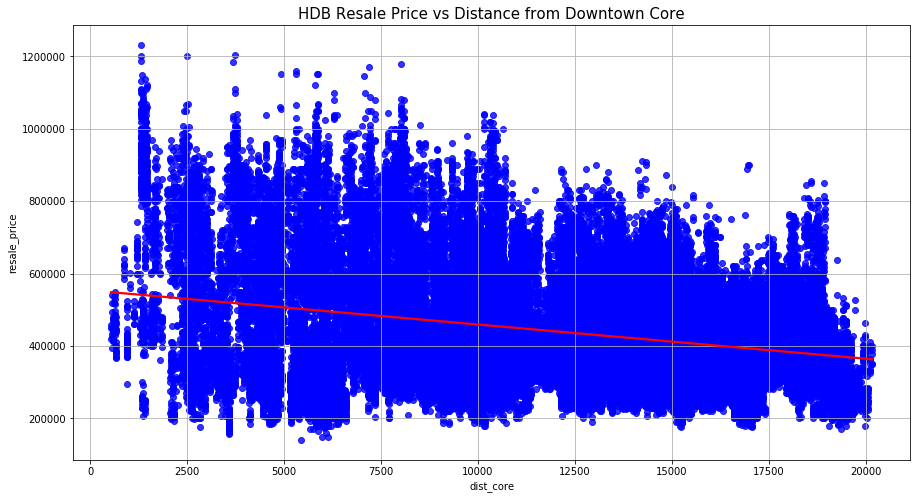

In [24]:
plot_poi(df,'dist_core','Downtown Core')